# **Evaluating Natural Language Generation w/ a RAG Architecture**

### Overview
In this notebook you will explore methods to evaluate NLG with a RAG (Retrieval Augmented Generation) architecture. RAG is a common method used to improve LLM results and reduce hallucnations by 'grounding' the LLM resposne using information retrieval. 

There are two important questions when evaluation a chatbot that uses RAG:
1. How good is the data being retreived (called the context) for a given question?
2. How good is my LLM at utilizing the provided context?  

For each of the questions above, there are two methods of assessment:
1. Groundedness - A LLM assessment of Groundedness (see [Notebook 1](./1_gpt_evaluation.ipynb) for details)
2. Similarity - The cosine similarity between the two embeddings vectors

The combination of question/method assessments discussed above leads to the use of 4 metrics. Question/Context Groundedness, Question/Context Similarity, Answer/Context Groundedness, and Answer/Context Similarity.

This notebook will use a sample Azure PromptFlow to generate chat responses using RAG, then explore a custom evaluation PromptFlow to assess the 4 metrics explained above.

 **_Go Deeper_**  
[OpenAI - Text Embedding and Similarity](https://openai.com/blog/introducing-text-and-code-embeddings)  
[GPT 4 can correctly classify binary relevence 86.3% of the time on average](https://arxiv.org/pdf/2312.09601.pdf)
  
**_Prerequisites_**  
  
Ensure that your environment is setup by completing the steps outlines in [0_setup.ipynb](./0_setup.ipynb)

## 1a. Setup Open AI embedding model connection

#TODO

## 1b. Upload Sample Input Data

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import os

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

In [7]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time

local_path = "../data/inputs/sample_rag_inputs.csv"
# set the version number of the data asset to the current UTC time
v1 = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())


my_data = Data(
    name="rag-chat-sample-inputs",
    version=v1,
    description="Sample inputs for rag chat flow",
    path=local_path,
    type=AssetTypes.URI_FILE,
)

# create data asset
ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Uploading sample_rag_inputs.csv (< 1 MB): 100%|██████████| 1.33k/1.33k [00:00<00:00, 24.0kB/s]




Data asset created. Name: rag-chat-sample-inputs, version: 2024.01.08.004855


## 2. Run Simple Chat & GPT Evaluation PromptFlow Jobs
In this section you will run a [sample RAG chat](../src/promptflow/sample_chat_flows/simplrag_chat) against a small sample dataset  

Then, as part of the same job, you will evaluate the GPT metrics above using an [evaluation PromptFlow](../src/promptflow/evaluation_flows/rag_gpt_eval/)

Both the simple chat and the evaluation utilize the AOAI connection established during setup and cooresponding GPT4 deployment

##### **IMPORTANT**: _Please take a moment to analyze in depth the Simple Chat, Evaluation Flow, and the sample dataset linked above_

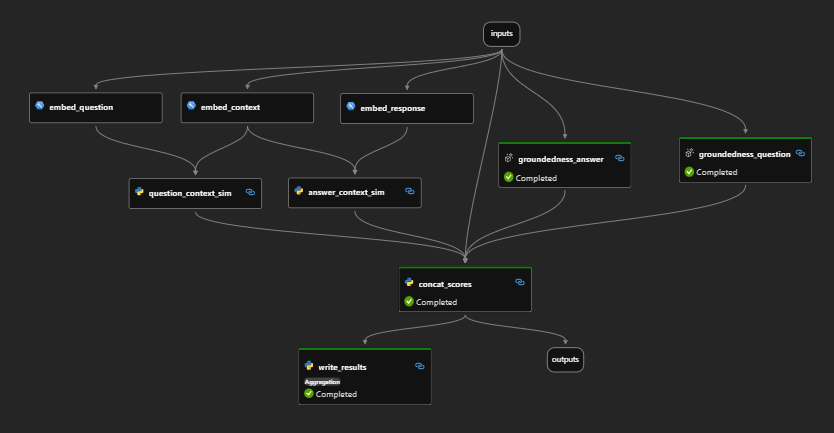

In [10]:
from promptflow import PFClient

# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
rag_chat_flow = "../src/promptflow/sample_chat_flows/rag_chat" # set the flow directory
rag_eval_flow = "../src/promptflow/evaluation_flows/rag_eval" # set flow directory
data = "../data/inputs/sample_rag_inputs.csv" # set the data file

# Run chat flow to generate chat results
rag_chat_run = pf.run(
    flow=rag_chat_flow,
    data=data,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "input": "${data.input}",
    }
)

# Run evaluation flow to evaluate chat results
rag_eval_run = pf.run(
    flow=rag_eval_flow,
    data=data,
    run=rag_chat_run,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "question": "${data.input}",
      "response": "${run.outputs.output}",
      "context": "${run.outputs.context}"
    }
)


2024-01-07 18:57:44 -0600  763342 promptflow_vectordb.tool INFO     [VectorIndexLookup] EmbeddingStore.Tool.Init started
2024-01-07 18:57:44 -0600  763342 promptflow_vectordb.tool INFO     [VectorIndexLookup] EmbeddingStore.Tool.LoadMLIndex started
2024-01-07 18:57:48 -0600  763342 promptflow_vectordb.tool INFO     [VectorIndexLookup] EmbeddingStore.Tool.LoadMLIndex completed
2024-01-07 18:57:48 -0600  763342 promptflow_vectordb.service INFO     [VectorIndexLookup] EmbeddingStore.Client.Init started
2024-01-07 18:57:48 -0600  763342 promptflow_vectordb.service INFO     [VectorIndexLookup] Agent instance: FileBasedAgent initialized
2024-01-07 18:57:48 -0600  763342 promptflow_vectordb.service INFO     [VectorIndexLookup] EmbeddingStore.Client.Init completed
2024-01-07 18:57:48 -0600  763342 promptflow_vectordb.core INFO     [VectorIndexLookup] Embedding instance: EmptyEmbedding initialized
2024-01-07 18:57:48 -0600  763342 promptflow_vectordb.tool INFO     [VectorIndexLookup] Adapter in

## 3.  View Results  
To view outputs in detail analyze the [output data](../data/outputs/rag_eval_results.json) directly

In [11]:
import pandas as pd

output_data = "../data/outputs/rag_eval_results.json"

output_df = pd.read_json(output_data)
display(output_df)

,question,answer,context,groundedness_answer,goundedness_question
0,How do I use the Python v2 Azure SDK?,To use the Azure Machine Learning Python SDK v...,An Azure Machine Learning workspace. To create...,5,5
